# 年輪データの状態空間モデル
* トレンドモデル

In [3]:
import os
from cmdstanpy import CmdStanModel
from pathlib import Path
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

## データ読込み

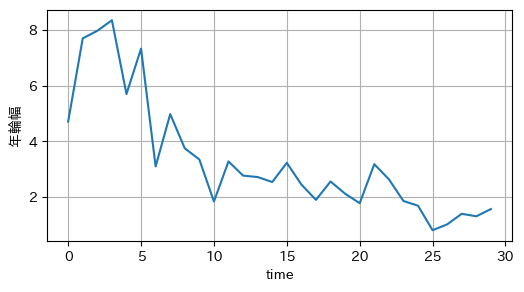

In [2]:
df = pd.read_csv("../data/nenrin.data", header=None)
df.columns = ["data"]

plt.figure(figsize=(6,3))
plt.plot(df["data"])
plt.xlabel("time")
plt.ylabel("年輪幅")
plt.grid()
plt.show()

In [8]:
stanfile = "../models_ts/lognormal_trend_nenrin.stan"
model = CmdStanModel(stan_file=stanfile)

15:49:17 - cmdstanpy - INFO - compiling stan file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/lognormal_trend_nenrin.stan to exe file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/lognormal_trend_nenrin
15:49:37 - cmdstanpy - INFO - compiled model executable: /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/lognormal_trend_nenrin


In [9]:
N_tr = df["data"].shape[0]
y_tr = df["data"].values
data = {
    "N_tr": N_tr,
    "y_tr": y_tr
}

In [10]:
fit = model.sample(
    data=data,
    iter_warmup=300, iter_sampling=1000, chains=3, show_console=False,
    adapt_delta=0.999,
    max_treedepth=20,
)

15:49:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration:  200 / 1300 [ 15%]  (Warmup)
chain 1 |██████████| 00:01 Iteration: 1200 / 1300 [ 92%]  (Sampling)










chain 1 |██████████| 00:46 Sampling completed                       
chain 2 |██████████| 00:46 Sampling completed                       
chain 3 |██████████| 00:46 Sampling completed                       


15:50:25 - cmdstanpy - INFO - CmdStan done processing.
15:50:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/lognormal_trend_nenrin.stan', line 22, column 4 to column 38)
Consider re-running with show_console=True if the above output is unclear!
15:50:25 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


In [11]:
# 念の為診断
print(fit.diagnose())

Processing csv files: /tmp/tmpmd3rasxk/lognormal_trend_nenrinr1idf_ga/lognormal_trend_nenrin-20230825154938_1.csv, /tmp/tmpmd3rasxk/lognormal_trend_nenrinr1idf_ga/lognormal_trend_nenrin-20230825154938_2.csv, /tmp/tmpmd3rasxk/lognormal_trend_nenrinr1idf_ga/lognormal_trend_nenrin-20230825154938_3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 3000 (0.03%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.05, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size satisfactory.

The following param

## 結果の確認

In [12]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,69.16380,9.738560,24.120900,35.460200,66.04930,115.16600,6.13473,0.103526,1.179450
alpha[1],1.91069,0.012835,0.200367,1.573110,1.91827,2.22830,243.70100,4.112550,1.021900
alpha[2],1.91392,0.003086,0.141767,1.679870,1.91556,2.14964,2110.37000,35.613200,1.001390
alpha[3],1.89548,0.016764,0.138165,1.668700,1.89468,2.12355,67.92770,1.146300,1.026090
alpha[4],1.84575,0.031251,0.145167,1.617430,1.83861,2.09614,21.57800,0.364136,1.049950
...,...,...,...,...,...,...,...,...,...
y_tr_hat[26],1.48963,0.015503,0.490037,0.844586,1.41195,2.39956,999.19000,16.861700,1.009230
y_tr_hat[27],1.39121,0.015813,0.456391,0.778511,1.32449,2.22971,833.02700,14.057600,1.007720
y_tr_hat[28],1.36408,0.008646,0.445345,0.763746,1.30206,2.18749,2653.06000,44.771400,1.001920
y_tr_hat[29],1.35235,0.008975,0.448099,0.771395,1.27765,2.18160,2492.96000,42.069600,0.999394


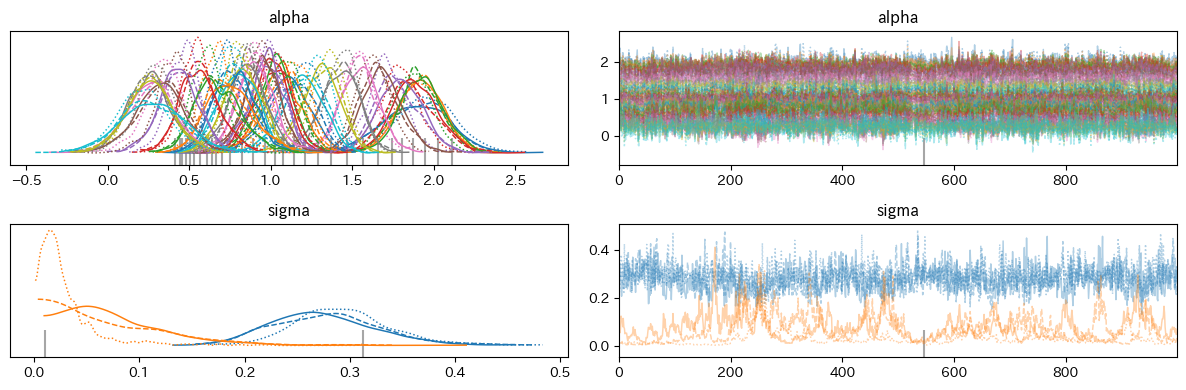

In [13]:
output = az.from_cmdstanpy(posterior=fit)
az.plot_trace(output, var_names=["alpha","sigma"])
plt.tight_layout()

## EAP推定
* 対数尤度が「異常度」の指標になる
* $\log L(y | \hat y, \sigma)$の意味
    * モデルが$\hat y$を推定したときにデータが$y$を取りうる確率の対数
    * 発生確率が小さくなるほど対数尤度も小さくなる
    * 発生確率が小さい＝めったに起こらない＝異常！と考える

In [14]:
samples = fit.stan_variables()

alpha = samples["alpha"].mean(0)
sigma = samples["sigma"].mean(0)
alpha, sigma

(array([1.91069157, 1.91392348, 1.89547946, 1.84574762, 1.76109519,
        1.65788132, 1.53976831, 1.43341642, 1.32704805, 1.22461139,
        1.13862067, 1.0883802 , 1.04685174, 1.01168626, 0.97909493,
        0.94349853, 0.89865625, 0.85533163, 0.82283334, 0.79020639,
        0.75757235, 0.72353625, 0.65733795, 0.55860918, 0.448157  ,
        0.34509191, 0.28724986, 0.26463002, 0.25724385, 0.25696634]),
 array([0.28270125, 0.05857567]))

In [15]:
y_tr_hat_lower, y_tr_hat_upper = np.quantile(samples["y_tr_hat"], [0.025,0.975], axis=0)
y_tr_hat_mean = samples["y_tr_hat"].mean(0)

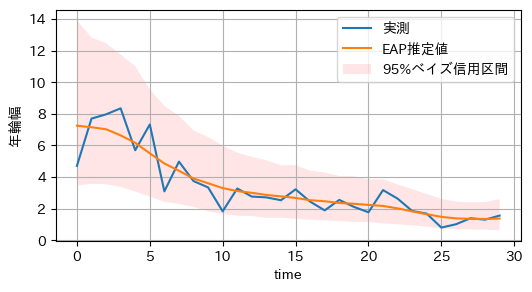

In [16]:
plt.figure(figsize=(6,3))
plt.plot(y_tr, label="実測")
plt.plot(y_tr_hat_mean, label="EAP推定値")
plt.fill_between(
    np.arange(N_tr), y1=y_tr_hat_lower, y2=y_tr_hat_upper, 
    alpha=0.1, color="r", edgecolor=None, label="95%ベイズ信用区間"
)
plt.xlabel("time")
plt.ylabel("年輪幅")
plt.grid()
plt.legend()
plt.show()

EOF